In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord, ResizeD

# ------------------------------------------------
# 1. Prepare the 2D Datasets and DataLoaders
# ------------------------------------------------

# Define paths to your 2D data directories
train_2d_dir = './dataset/train_2d'
val_2d_dir = './dataset/val_2d'

# Build the list of 2D training samples.
train_data_2d = []
for patient in os.listdir(train_2d_dir):
    patient_path = os.path.join(train_2d_dir, patient)
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith('.nii') and '_gt' not in file:
                image_path = os.path.join(patient_path, file)
                # Construct the corresponding ground truth filename.
                if '_slice' in file:
                    parts = file.split('_slice')
                    gt_file = parts[0] + '_gt_slice' + parts[1]
                else:
                    gt_file = file.replace('.nii', '_gt.nii')
                gt_path = os.path.join(patient_path, gt_file)
                if os.path.exists(gt_path):
                    train_data_2d.append({"image": image_path, "label": gt_path})
                else:
                    print("Warning: No corresponding ground truth for", image_path)
print(f"Found {len(train_data_2d)} 2D training samples.")

# Build the list of 2D validation samples.
val_data_2d = []
for patient in os.listdir(val_2d_dir):
    patient_path = os.path.join(val_2d_dir, patient)
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith('.nii') and '_gt' not in file:
                image_path = os.path.join(patient_path, file)
                if '_slice' in file:
                    parts = file.split('_slice')
                    gt_file = parts[0] + '_gt_slice' + parts[1]
                else:
                    gt_file = file.replace('.nii', '_gt.nii')
                gt_path = os.path.join(patient_path, gt_file)
                if os.path.exists(gt_path):
                    val_data_2d.append({"image": image_path, "label": gt_path})
                else:
                    print("Warning: No corresponding ground truth for", image_path)
print(f"Found {len(val_data_2d)} 2D validation samples.")

# Define transforms for both training and validation.
# Here we add a ResizeD transform to force every image to be 352x352.
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(352, 352)),
    ToTensord(keys=["image", "label"]),
])

# Create MONAI datasets.
train_ds_2d = Dataset(data=train_data_2d, transform=transforms)
val_ds_2d = Dataset(data=val_data_2d, transform=transforms)

# Create DataLoaders using a padded collate function.
train_loader_2d = DataLoader(train_ds_2d, batch_size=10, shuffle=True, collate_fn=pad_list_data_collate)
val_loader_2d = DataLoader(val_ds_2d, batch_size=10, shuffle=False, collate_fn=pad_list_data_collate)

# ------------------------------------------------
# 2. Build the 2D U-Net Model and Training Setup
# ------------------------------------------------

in_channels = 1           # grayscale images
out_channels = 4          # e.g., background + 3 regions
initial_features = 48

channels = (initial_features, initial_features*2, initial_features*4, initial_features*8)
strides = (2, 2, 2)
num_res_units = 2

# Use "batch" for normalization.
model = UNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=num_res_units,
    norm="batch",
)

# ------------------------------------------------
# Weighted Cross-Entropy Loss
# ------------------------------------------------
# Define class weights (example values – adjust as needed).
class_weights = torch.tensor([0.2, 0.3, 0.3, 0.2], device="cuda" if torch.cuda.is_available() else "cpu", dtype=torch.float)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ------------------------------------------------
# 3. Training Loop Using Weighted Cross-Entropy Loss
# ------------------------------------------------

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_data in train_loader_2d:
        inputs = batch_data["image"].to(device)   # shape: (B, 1, 352, 352)
        labels = batch_data["label"].to(device)     # shape: (B, 1, 352, 352)
        # Squeeze out the channel dimension so labels become (B, 352, 352) with integer values.
        labels = labels.squeeze(1).long()
        
        optimizer.zero_grad()
        outputs = model(inputs)                     # outputs: (B, 4, 352, 352)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader_2d)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_loss:.4f}")
    
    # Validation loop.
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_data in val_loader_2d:
            val_inputs = val_data["image"].to(device)
            val_labels = val_data["label"].to(device).squeeze(1).long()
            val_outputs = model(val_inputs)
            loss_val = loss_function(val_outputs, val_labels)
            val_loss += loss_val.item()
        avg_val_loss = val_loss / len(val_loader_2d)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")


2025-02-24 13:33:05.964246: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 13:33:06.003099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 13:33:06.003121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 13:33:06.003138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 13:33:06.010453: I tensorflow/core/platform/cpu_feature_g

Found 1526 2D training samples.
Found 376 2D validation samples.
Epoch 1/10, Average Training Loss: 1.1372
Epoch 1/10, Validation Loss: 0.9744
Epoch 2/10, Average Training Loss: 0.8823
Epoch 2/10, Validation Loss: 0.7770
Epoch 3/10, Average Training Loss: 0.6986
Epoch 3/10, Validation Loss: 0.6083
Epoch 4/10, Average Training Loss: 0.5327
Epoch 4/10, Validation Loss: 0.4586
Epoch 5/10, Average Training Loss: 0.3760
Epoch 5/10, Validation Loss: 0.3281
Epoch 6/10, Average Training Loss: 0.2663
Epoch 6/10, Validation Loss: 0.2413
Epoch 7/10, Average Training Loss: 0.1930
Epoch 7/10, Validation Loss: 0.1936
Epoch 8/10, Average Training Loss: 0.1414
Epoch 8/10, Validation Loss: 0.1352
Epoch 9/10, Average Training Loss: 0.1106
Epoch 9/10, Validation Loss: 0.1143
Epoch 10/10, Average Training Loss: 0.0922
Epoch 10/10, Validation Loss: 0.0980
Training complete.


Model checkpoint saved.


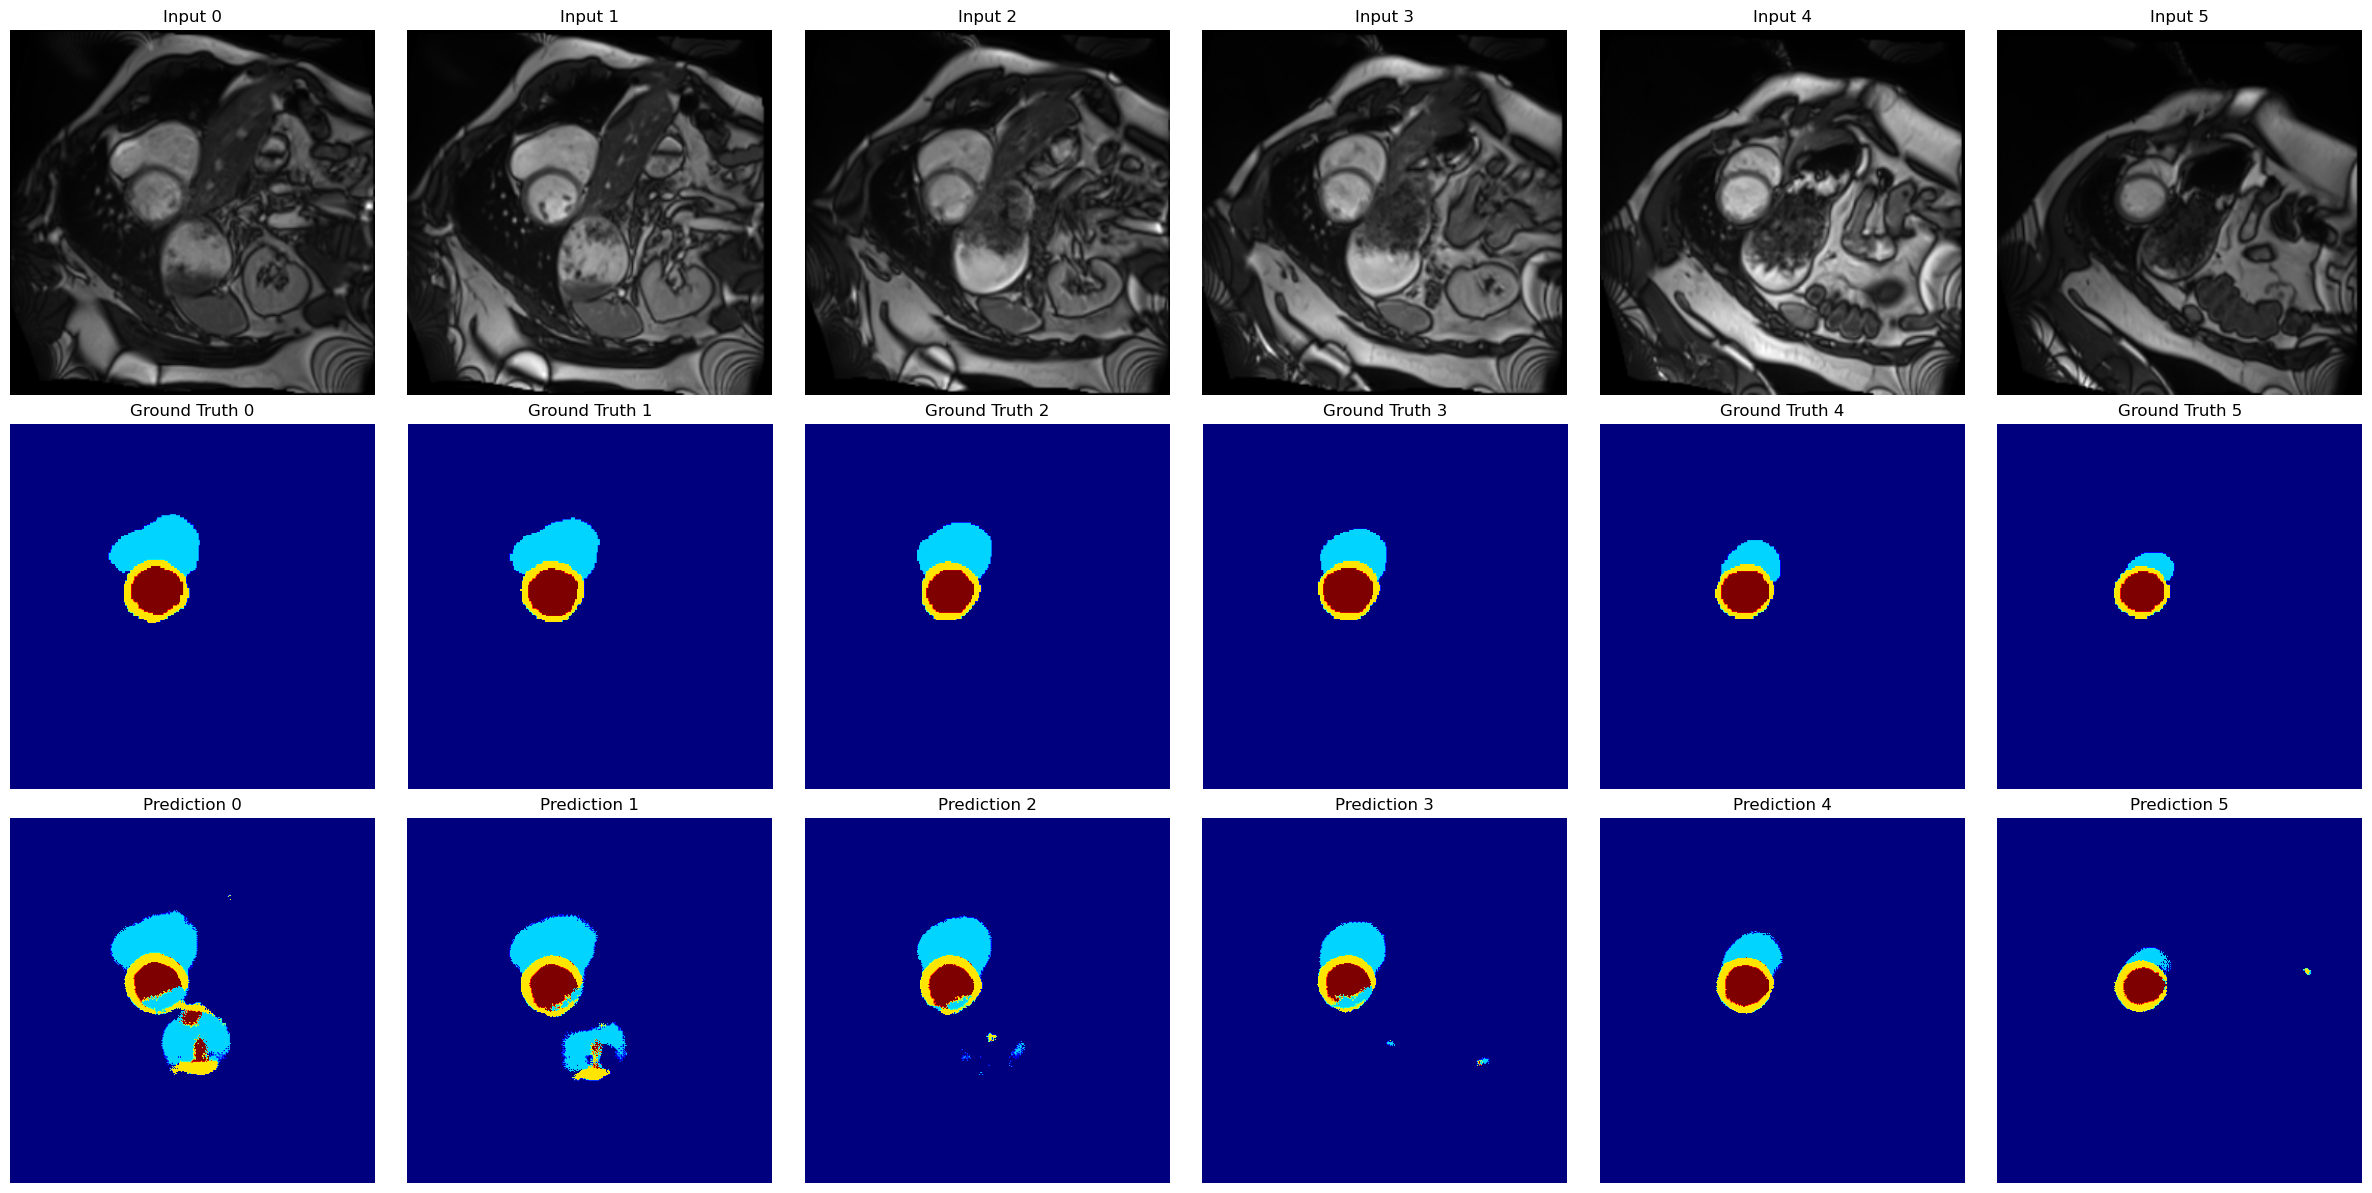

/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Dice Score: 0.6907
Hausdorff Distance (95th percentile): 59.6747
Pixel-wise Accuracy: 0.9871


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.metrics import DiceMetric, HausdorffDistanceMetric

# 1. Save the model checkpoint.
torch.save(model.state_dict(), "2d_unet_checkpoint_first_model_celoss.pth")
print("Model checkpoint saved.")

# 2. Visualize predictions on a validation batch.
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader_2d))
    inputs = batch["image"].to(device)
    labels = batch["label"].to(device)
    outputs = model(inputs)
    # Get the predicted segmentation as the argmax over the channel dimension.
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

# Move inputs and labels to CPU for visualization.
inputs = inputs.cpu().numpy()   # shape: (B, 1, H, W)
labels = labels.cpu().numpy()   # shape: (B, 1, H, W)

# Number of samples to display.
num_to_show = min(6, inputs.shape[0])
fig, axs = plt.subplots(3, num_to_show, figsize=(4*num_to_show, 12))
for i in range(num_to_show):
    # Input image.
    axs[0, i].imshow(inputs[i, 0, :, :], cmap="gray")
    axs[0, i].set_title(f"Input {i}")
    axs[0, i].axis("off")
    # Ground truth.
    axs[1, i].imshow(labels[i, 0, :, :], cmap="jet")
    axs[1, i].set_title(f"Ground Truth {i}")
    axs[1, i].axis("off")
    # Prediction.
    axs[2, i].imshow(preds[i, :, :], cmap="jet")
    axs[2, i].set_title(f"Prediction {i}")
    axs[2, i].axis("off")
plt.tight_layout()
plt.show()

# 3. Evaluate the model on the full validation set.
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
hd_metric = HausdorffDistanceMetric(include_background=True, percentile=95)

total_correct = 0
total_pixels = 0

model.eval()
with torch.no_grad():
    for val_batch in val_loader_2d:
        val_inputs = val_batch["image"].to(device)
        val_labels = val_batch["label"].to(device)
        val_outputs = model(val_inputs)
        # Obtain predictions.
        preds_batch = torch.argmax(val_outputs, dim=1, keepdim=True)  # shape: (B, 1, H, W)
        # Update metrics.
        dice_metric(y_pred=preds_batch, y=val_labels)
        hd_metric(y_pred=preds_batch, y=val_labels)
        # Pixel-wise accuracy.
        total_correct += (preds_batch == val_labels).sum().item()
        total_pixels += torch.numel(val_labels)

dice_score = dice_metric.aggregate().item()
hd_score = hd_metric.aggregate().item()
accuracy = total_correct / total_pixels

print(f"Dice Score: {dice_score:.4f}")
print(f"Hausdorff Distance (95th percentile): {hd_score:.4f}")
print(f"Pixel-wise Accuracy: {accuracy:.4f}")
